In [7]:
import pickle
import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization, LeakyReLU
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from utils import S2FPS, S2DES, S2MAC

In [8]:
data_file = 'train.csv'
model_file = 'rt_prediction_model.h5'
lab_file = 'label_encoder.pkl'
scale_file = 'scaler.pkl'
struc_file = 'model_structure.pdf'
dot_file = 'dot_plot.pdf'

In [9]:
data = pd.read_csv(data_file)

X_fps = np.array([S2FPS(s) for s in data['SMILES']])
X_des = np.array([S2DES(s) for s in data['SMILES']])
X_mac = np.array([S2MAC(s) for s in data['SMILES']])

# Lab one-hot Encoder
le = LabelEncoder()
lab_encoded = le.fit_transform(data['Lab'])
with open(lab_file, 'wb') as f:
    pickle.dump(le, f)
num_labs = len(le.classes_)
X_lab = np.eye(num_labs)[lab_encoded]

[23:38:08] DEPRECATION WARNING: please use MorganGenerator
[23:38:08] DEPRECATION WARNING: please use MorganGenerator
[23:38:08] DEPRECATION WARNING: please use MorganGenerator
[23:38:08] DEPRECATION WARNING: please use MorganGenerator
[23:38:08] DEPRECATION WARNING: please use MorganGenerator
[23:38:08] DEPRECATION WARNING: please use MorganGenerator
[23:38:08] DEPRECATION WARNING: please use MorganGenerator
[23:38:08] DEPRECATION WARNING: please use MorganGenerator
[23:38:08] DEPRECATION WARNING: please use MorganGenerator
[23:38:08] DEPRECATION WARNING: please use MorganGenerator
[23:38:08] DEPRECATION WARNING: please use MorganGenerator
[23:38:08] DEPRECATION WARNING: please use MorganGenerator
[23:38:08] DEPRECATION WARNING: please use MorganGenerator
[23:38:08] DEPRECATION WARNING: please use MorganGenerator
[23:38:08] DEPRECATION WARNING: please use MorganGenerator
[23:38:08] DEPRECATION WARNING: please use MorganGenerator
[23:38:08] DEPRECATION WARNING: please use MorganGenerat

In [10]:
# train test split
X_fps_train, X_fps_test, X_des_train, X_des_test, X_mac_train, X_mac_test, X_lab_train, X_lab_test, y_train, y_test = train_test_split(
    X_fps, X_des, X_mac, X_lab, data['RT'], test_size=0.1, random_state=12)

# Standard Scaler
scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1)).flatten()
with open(scale_file, 'wb') as f:
    pickle.dump(scaler, f)


def create_model(input_shape_fps, input_shape_des, input_shape_mac, input_shape_lab):
    fps_input = Input(shape=input_shape_fps)
    des_input = Input(shape=input_shape_des)
    mac_input = Input(shape=input_shape_mac)
    lab_input = Input(shape=input_shape_lab)

    # ECFP + MACCS Branch
    x1 = Dense(1024, kernel_regularizer=l2(0.01))(fps_input)
    x1 = BatchNormalization()(x1)
    x1 = LeakyReLU()(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Dense(512, kernel_regularizer=l2(0.01))(x1)
    x1 = BatchNormalization()(x1)
    x1 = LeakyReLU()(x1)
    x1 = Dropout(0.3)(x1)

    # Descriptors Branch
    x2 = Dense(128, kernel_regularizer=l2(0.01))(des_input)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU()(x2)
    x2 = Dropout(0.3)(x2)

    # MACCS Branch
    x3 = Dense(128, kernel_regularizer=l2(0.01))(mac_input)
    x3 = BatchNormalization()(x3)
    x3 = LeakyReLU()(x3)
    x3 = Dropout(0.3)(x3)

    # Lab one-hot Branch
    x4 = Dense(128, kernel_regularizer=l2(0.01))(lab_input)
    x4 = BatchNormalization()(x4)
    x4 = LeakyReLU()(x4)
    x4 = Dropout(0.3)(x4)

    merged = Concatenate()([x1, x2, x3, x4])
    merged = Dense(256, kernel_regularizer=l2(0.01))(merged)
    merged = BatchNormalization()(merged)
    merged = LeakyReLU()(merged)
    merged = Dropout(0.3)(merged)

    output = Dense(1)(merged)

    model = Model(inputs=[fps_input, des_input, mac_input, lab_input], outputs=output)
    return model

model = create_model(X_fps.shape[1], X_des.shape[1], X_mac.shape[1], num_labs)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.000005)

In [11]:
history = model.fit(
    [X_fps_train, X_des_train, X_mac_train, X_lab_train], 
    y_train_scaled,
    validation_data=([X_fps_test, X_des_test, X_mac_test, X_lab_test], y_test_scaled),
    epochs=200, 
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

y_pred_scaled = model.predict([X_fps_test, X_des_test, X_mac_test, X_lab_test])
y_pred = scaler.inverse_transform(y_pred_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared Score: {r2}")

model.save(model_file)

Epoch 1/200
107/107 [==============================] - 3s 12ms/step - loss: 17.6470 - val_loss: 13.4041 - lr: 0.0010
Epoch 2/200
107/107 [==============================] - 1s 11ms/step - loss: 10.0993 - val_loss: 7.6484 - lr: 0.0010
Epoch 3/200
107/107 [==============================] - 1s 11ms/step - loss: 5.8853 - val_loss: 4.5335 - lr: 0.0010
Epoch 4/200
107/107 [==============================] - 1s 11ms/step - loss: 3.4230 - val_loss: 2.7621 - lr: 0.0010
Epoch 5/200
107/107 [==============================] - 1s 11ms/step - loss: 2.0655 - val_loss: 1.7364 - lr: 0.0010
Epoch 6/200
107/107 [==============================] - 1s 11ms/step - loss: 1.2749 - val_loss: 1.0844 - lr: 0.0010
Epoch 7/200
107/107 [==============================] - 1s 11ms/step - loss: 0.8311 - val_loss: 0.8172 - lr: 0.0010
Epoch 8/200
107/107 [==============================] - 1s 11ms/step - loss: 0.5812 - val_loss: 0.5618 - lr: 0.0010
Epoch 9/200
107/107 [==============================] - 1s 11ms/step - loss: 0

d:\Program Files\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


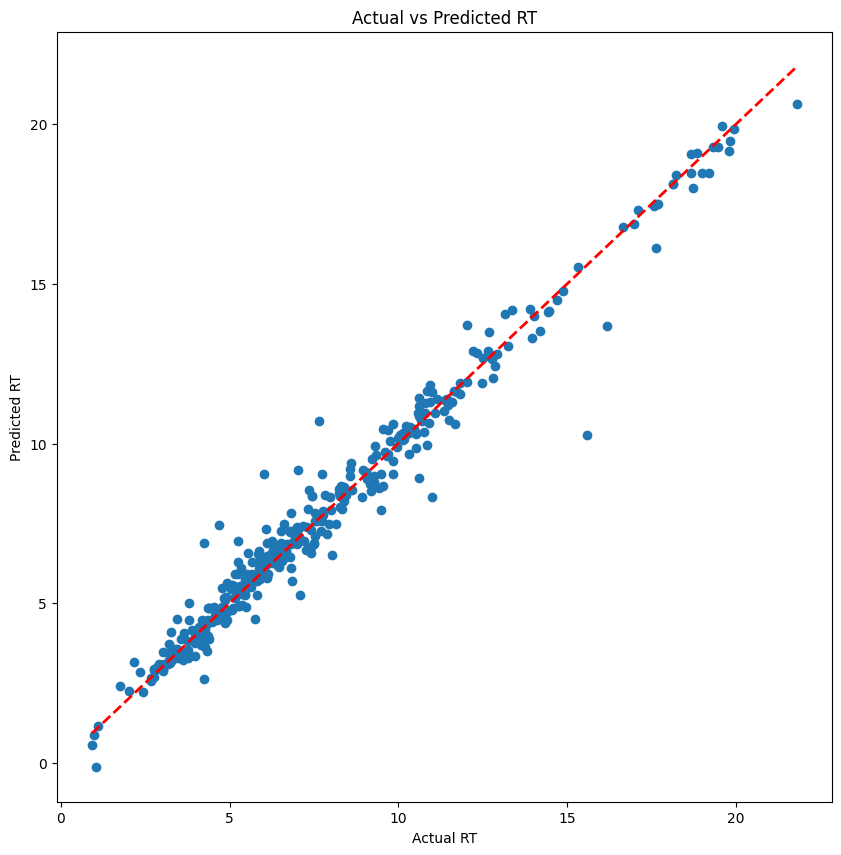

In [12]:
from keras.utils import plot_model
import matplotlib.pyplot as plt

plot_model(model, to_file=struc_file, show_shapes=True, show_layer_names=True)

plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual RT")
plt.ylabel("Predicted RT")
plt.title("Actual vs Predicted RT")
plt.savefig(dot_file)